In [2]:
#Usaremos el set de datos mnist de TensorFlow
import tensorflow as tf
import tensorflow_datasets as tfds

In [4]:
#Descargar el set de datos con metadatos
datos, metadatos = tfds.load("mnist",as_supervised=True, with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling C:\Users\eobga\tensorflow_datasets\mnist\3.0.1.incomplete1WY2AX\mnist-train.tfrecord*...:   0%|     …

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling C:\Users\eobga\tensorflow_datasets\mnist\3.0.1.incomplete1WY2AX\mnist-test.tfrecord*...:   0%|      …

Dataset mnist downloaded and prepared to C:\Users\eobga\tensorflow_datasets\mnist\3.0.1. Subsequent calls will reuse this data.


In [5]:
metadatos

tfds.core.DatasetInfo(
    name='mnist',
    full_name='mnist/3.0.1',
    description="""
    The MNIST database of handwritten digits.
    """,
    homepage='http://yann.lecun.com/exdb/mnist/',
    data_dir='C:\\Users\\eobga\\tensorflow_datasets\\mnist\\3.0.1',
    file_format=tfrecord,
    download_size=11.06 MiB,
    dataset_size=21.00 MiB,
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=10),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=10000, num_shards=1>,
        'train': <SplitInfo num_examples=60000, num_shards=1>,
    },
    citation="""@article{lecun2010mnist,
      title={MNIST handwritten digit database},
      author={LeCun, Yann and Cortes, Corinna and Burges, CJ},
      journal={ATT Labs [Online]. Available: http://yann.lecun.com/exdb/mnist},
      volume={2},
      year={2010}
    }""",
)

In [6]:
datos_entrenamiento = datos["train"]
datos_pruebas = datos["test"]

In [8]:
nombres_clases = metadatos.features["label"].names

In [9]:
#Normalizacion
#0-255 (valores de pixeles <<Blanco-negro>>) La normalizacion cambia esto de (0-1)
#Transformar 0-255 -> 0-1 (0=0 , 255 = 1) por lo cual 127=.5

#Normalizar los datos de entrenamiento y prueba
def normalizar(imagenes, etiquetas):
    imagenes = tf.cast(imagenes, tf.float32) #convertir imagenes a float para poder dividirlo
    imagenes = imagenes/255 #dividirlo en 255 para tener 0-1
    return imagenes, etiquetas

datos_entrenamiento = datos_entrenamiento.map(normalizar)
datos_pruebas = datos_pruebas.map(normalizar)

#Agregar en cache para que los guarde en memoria ,esto hara que las siguientes vueltas sean mas rapidas
datos_entrenamiento = datos_entrenamiento.cache()
datos_pruebas = datos_pruebas.cache()

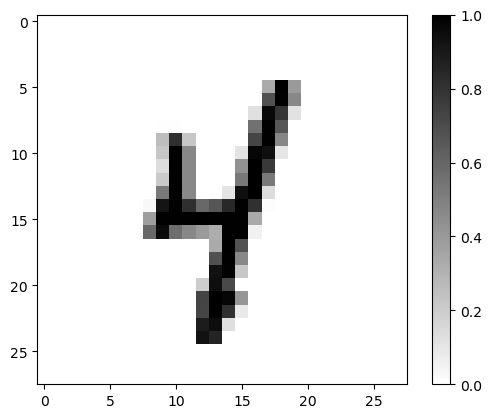

In [30]:
#Mostrar 1 dato en pantalla
for imagen, etiqueta in datos_entrenamiento.take(1):
    break

import matplotlib.pyplot as plt 

#Mostrarlo en pantalla
plt.figure()
plt.imshow(imagen, cmap=plt.cm.binary) #Solo pintar blanco y negro
plt.colorbar() #Agregar barra de colores para observar el (0-1)
plt.show()

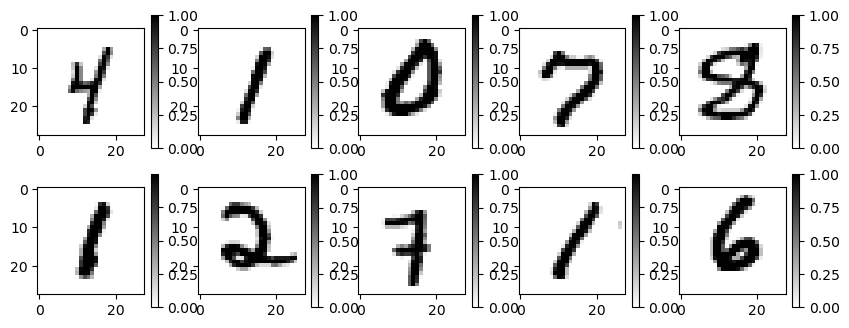

In [32]:
plt.figure(figsize=(10,10))
for i, (imagen, etiqueta) in enumerate(datos_entrenamiento.take(10)): #usamos enumerate para generar un index
    #Mostrar varios en pantalla
    plt.subplot(5,5, i+1)
    plt.imshow(imagen, cmap=plt.cm.binary) #Solo pintar blanco y negro
    plt.colorbar() #Agregar barra de colores para observar el (0-1)
plt.show()